Here we will put all the function at the same time, then after we will execute one after another our main

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import scipy.stats as sp
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
import statsmodels.api as sm
#from bayes_opt import BayesianOptimization

In [2]:
# Function to explore the data
def explore_data(df):

    print(df.describe())
    print(df.isnull().sum())
    print(df.dtypes)

# Function for feature engineering
def engineer_features1(df):
    df.set_index('Date', inplace= True)
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek # this is a panda function that give the nmber of the date (weeknd are 5, 6) Monday is 0
    df['Month'] = df['Date'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    return df

def engineer_features(df):
    # If 'Date' is not the index, set it as the index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    # Extract time-based features from the index
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek  # pandas function that gives the number of the day of the week (0 is Monday)
    df['Month'] = df.index.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 correspond to Saturday and Sunday
    
    return df


# Function for data cleaning
def clean_data(df):
    df.fillna(df.mean(), inplace=True)  # Example: fill missing values with the mean
    # Add other data cleaning steps here
    return df

In [3]:
def show_correlation1(df, target_variable):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Select correlations related to the target variable
    target_corr = corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False)

    # Create a figure
    plt.figure(figsize=(8, 10))

    # Plot heatmap of the sorted target variable correlations
    sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f'Feature Correlation with {target_variable}')
    plt.show()

def show_correlation(df, target_variable):
    methods = ['pearson', 'spearman', 'kendall']
    for method in methods:
        # Calculate the correlation matrix using different methods
        corr_matrix = df.corr(method=method)

        # Select correlations related to the target variable
        target_corr = corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False)

        # Create a figure for each correlation method
        plt.figure(figsize=(8, 10))
        sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
        plt.title(f'Feature Correlation with {target_variable} ({method.capitalize()})')
        plt.show()
def show_cross_correlation(df, target_variable, method='spearman', title= ""):
    # Calculate the Spearman rank correlation matrix
    corr_matrix = df.corr(method=method)

    # Generate a mask for the upper triangle (optional, for aesthetics)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f'Feature Cross Correlation (Spearman){title}')
    plt.show()


In [4]:
# this function is for scalling 
def transform_data(df, target_column_name, exclude_from_scaling=None):
    if exclude_from_scaling is None:
        exclude_from_scaling = []

    # Set 'Date' as the index if it's not already, assuming 'Date' is the name of your datetime column
    if 'Date' in df.columns:
        df.set_index('Date', inplace=True)

    # Ensure 'Date' column is excluded from scaling by not adding it to X
    X = df.drop([target_column_name] + exclude_from_scaling, errors='ignore', axis=1)
    y = df[target_column_name]

    scaler = StandardScaler()
    # Only scale columns that are not excluded
    X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.select_dtypes(include=[np.number]).columns, index=X.index)

    # Re-include the excluded features without scaling
    X_excluded = df[exclude_from_scaling]
    X_final = pd.concat([X_scaled_df, X_excluded], axis=1)

    print("Make sure transformation is well done:")
    print(X_final.head())
    return X_final, y

In [5]:
# Function to split the data, but this shouldn't be applied for time series as it supposes the variables as random
# so we will use the one after which is used for time series
def split_data1(X, y, test_size=0.2, random_state=203):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def split_data(X, y, dates, test_size=0.2):
    split_point = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    dates_train, dates_test = dates[:split_point], dates[split_point:]
    return X_train, X_test, y_train, y_test, dates_train, dates_test

We Use the Multiple Splits Function: This function is beneficial for thoroughly testing and validating your model across different time windows. It provides insights into how the model performs as more data becomes available, and helps you understand how stable and robust your model is under varying conditions. \\


Objective: Use this approach to adjust hyperparameters, try different model architectures, and test different feature sets to see how changes affect performance across multiple time periods.


Advantage: This method provides a comprehensive view of model performance and helps ensure that your model is not overfitting to a specific time period.

We Use the Single Last Split Function: Once you are satisfied with your model's performance and have finalized your tuning, switch to using the function that returns only the last split. This setup maximizes the amount of training data you use and tests the model on the most recent data, which is typically what you'd do in a production environment or for a final evaluation before deployment.
Objective: Prepare the model for real-world application by training it on the fullest extent of historical data available and evaluating it on the most recent, unseen data segment.
Advantage: Maximizes the use of available data and provides a realistic assessment of how the model will perform when making actual forecasts after deployment.

In [6]:
def time_series_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_indices = []
    test_indices = []
    X_train, X_test, y_train, y_test = None, None, None, None

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Collect all train and test indices
        train_indices.append(train_index)
        test_indices.append(test_index)

    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [7]:
###
    # we start with SVR, but it will works with others models
def train_model(X_train, y_train, technique, params):
    """
    Trains an SVR model based on the specified technique and parameters.

    :param X_train: Training feature dataset.
    :param y_train: Training target dataset.
    :param technique: Specifies the technique to use.
                      "SVR default" for default parameters, "SVR" for custom parameters.
    :param params: Dictionary of parameters for the SVR model.
    :return: Trained SVR model.
    """
    if technique == "SVR default":
        model = SVR()
    elif technique == "SVR":
        model = SVR(**params)
    else:
        raise ValueError("Unsupported technique specified.")

    model.fit(X_train, y_train)
    return model

In [82]:
def evaluate_model(model, X_test, y_test):
    """

    :type model: this is a trained model, and it's coming from the returned value of train_model
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    # Print the evaluation metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean absolute percentage error: {mape}")
    return predictions, mse, mae, rmse, r2

In [9]:
def perform_grid_search(X_train, y_train):  # i don't like it. it only works with SVR, but we will leave it to later
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [10]:
def perform_random_search(X_train, y_train, model, param_dist, n_iter=100):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=203)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_score_

In [11]:
def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

In [12]:
def plotting1(predictions, y_test):
    plt.figure(figsize=(14, 7))
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.plot(y_test.values, label='Actual', alpha=0.5)  # Ensure y_test is a series, so we access .values
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Time/Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plotting(predictions, y_test, dates):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)  # Use dates on the x-axis
    plt.plot(dates, y_test, label='Actual', alpha=0.5)  # Ensure y_test is plotted with dates
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()
'''
here we had problems in plotting. this plotting method isn't adapted for time series split and also we weren't indexing the dates
'''

"\nhere we had problems in plotting. this plotting method isn't adapted for time series split and also we weren't indexing the dates\n"

In [13]:
def plot_all_folds(model, X, y, test_indices):
    plt.figure(figsize=(14, 7))
    for index in test_indices:
        # Make predictions for each test set
        X_test = X.iloc[index]
        y_test = y.iloc[index]
        predictions = model.predict(X_test)

        # Plot
        plt.plot(X_test.index, predictions, label='Predicted', alpha=0.7)
        plt.plot(X_test.index, y_test, label='Actual', alpha=0.5)
    
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.show()

In [14]:

def plot_training_testing(model, X, y, train_indices, test_indices):
    plt.figure(figsize=(15, 8))

    # Configure the x-axis to better handle dates
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Plot a subset or downsample
    subset_size = 1000  # Adjust as needed for visibility
    for train_idx in train_indices:
        X_train = X.iloc[train_idx].iloc[-subset_size:]
        y_train = y.iloc[train_idx].iloc[-subset_size:]
        plt.plot(X_train.index, y_train, 'b-', label='Training data' if train_idx is train_indices[0] else "", alpha=0.1)
    
    for test_idx in test_indices:
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
        predictions = model.predict(X_test)
        plt.plot(X_test.index, y_test, 'g-', label='Actual Test' if test_idx is test_indices[0] else "", alpha=0.5)
        plt.plot(X_test.index, predictions, 'r--', label='Predicted Test' if test_idx is test_indices[0] else "", alpha=0.5)

    plt.title('Model Performance on Training and Testing Data')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to ensure no label cut-off
    plt.show()

In [15]:
# this plotting only show the last testing phase, which the only interesting part 
def plot_last_test_set_predictions(model, X, y, train_indices, test_indices):
    # Get the last test index
    last_test_index = test_indices[-1]

    # Extract the last test set
    X_test = X.iloc[last_test_index]
    y_test = y.iloc[last_test_index]

    # Predict on the last test set
    predictions = model.predict(X_test)

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(X_test.index, predictions, label='Predicted', alpha= 0.7)
    plt.plot(X_test.index, y_test, label='Actual', alpha= 0.5)
    

    # Format the x-axis to handle dates better
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Auto-rotates the date labels

    plt.title('Actual vs. Predicted Values on the Last Testing Set')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.tight_layout()  # Adjust layout to ensure no label cut-off
    plt.show()
# Make sure to use the correct model, features 'X_scaled', target 'y', and the indices 'train_indices', 'test_indices

In [16]:
def feature_significance_analysis(data, target_variable):
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    X = sm.add_constant(X)  # adding a constant
    model = sm.OLS(y, X).fit()
    return model.summary()

bissmillah let's run

       Cross border electricity trading      Nuclear  Non-Renewable  \
count                       8759.000000  2519.000000    8759.000000   
mean                        1340.004423  2671.735395   18986.206568   
std                         6959.067853   315.463966    8992.920305   
min                       -19226.890000   271.760000    5911.920000   
25%                        -3548.875000  2410.400000   11942.110000   
50%                         1591.410000  2795.050000   16867.600000   
75%                         6688.470000  2942.390000   23744.935000   
max                        17081.870000  3075.230000   45386.800000   

          Renewable          Load  Day Ahead Auction  \
count   8759.000000   8759.000000        8759.000000   
mean   29719.784032  52248.311433          95.186317   
std    12685.754954   9057.096572          47.576064   
min     7956.630000  30908.880000        -500.000000   
25%    18862.475000  44767.280000          75.885000   
50%    28603.180000  522

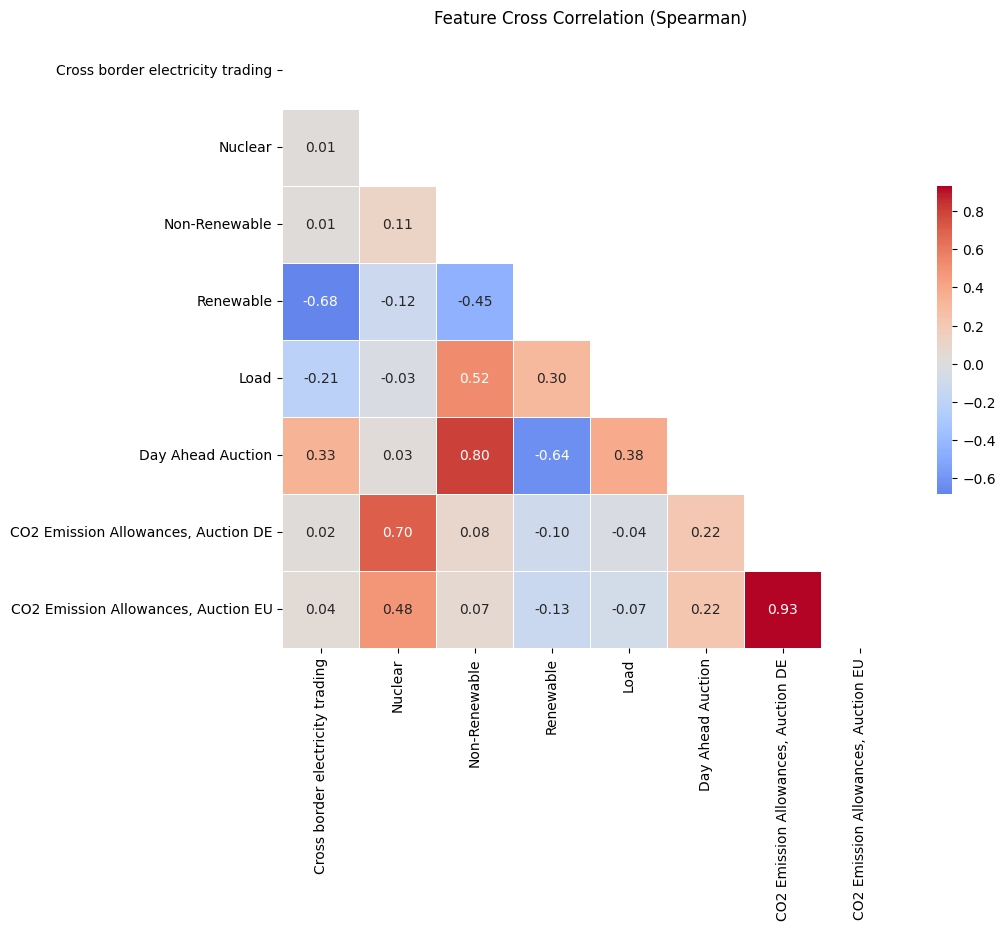

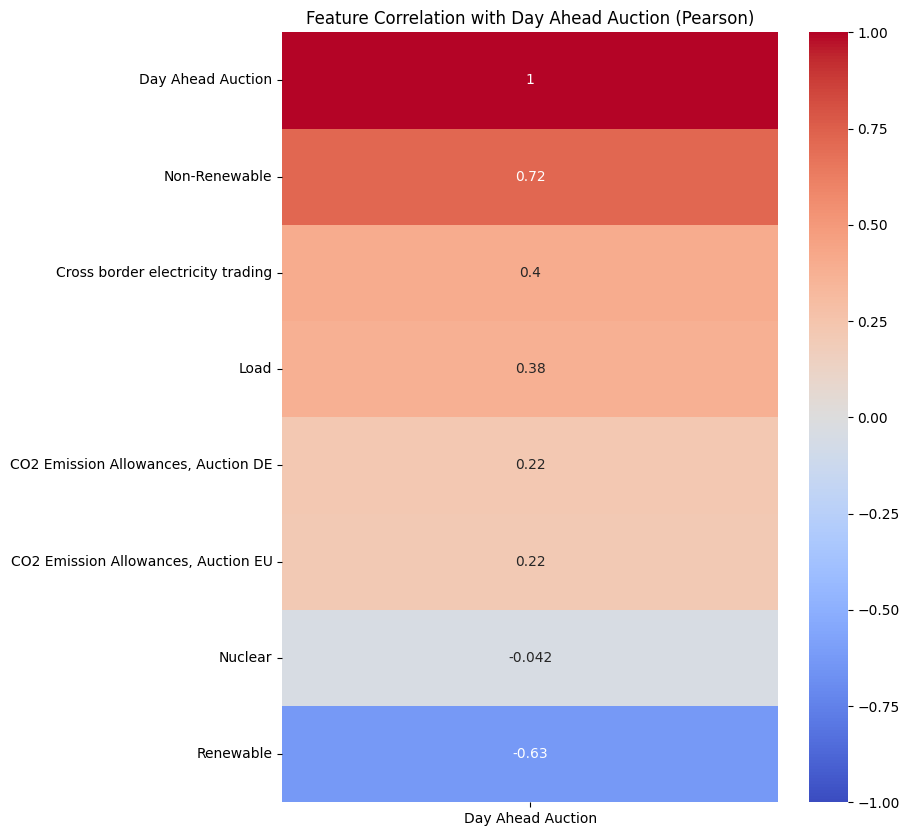

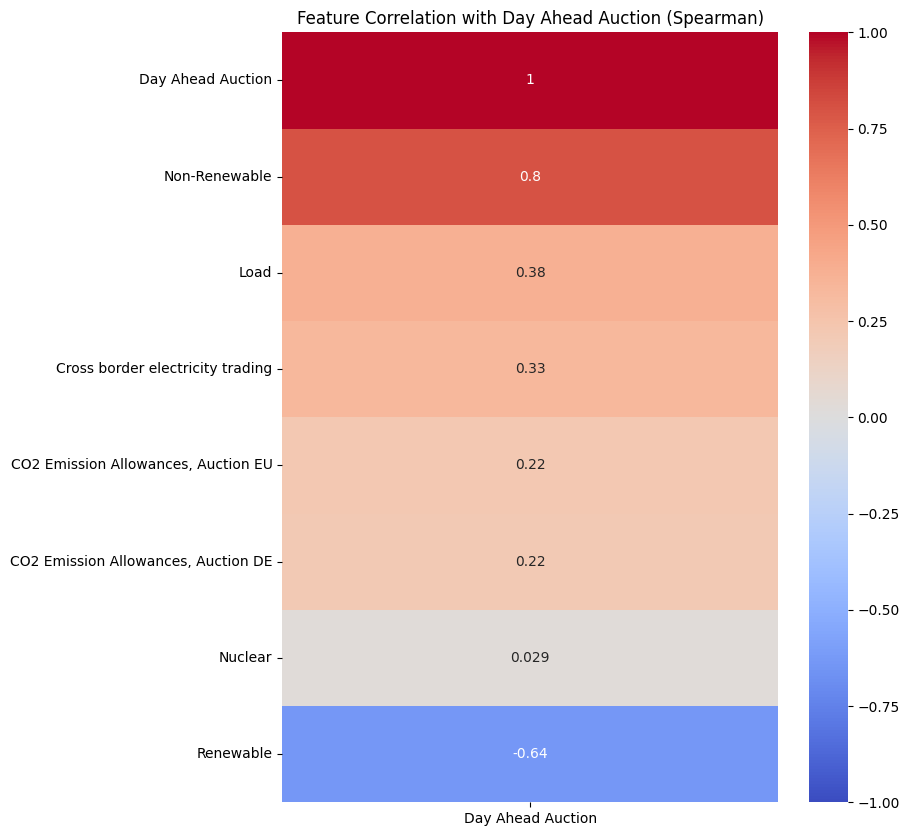

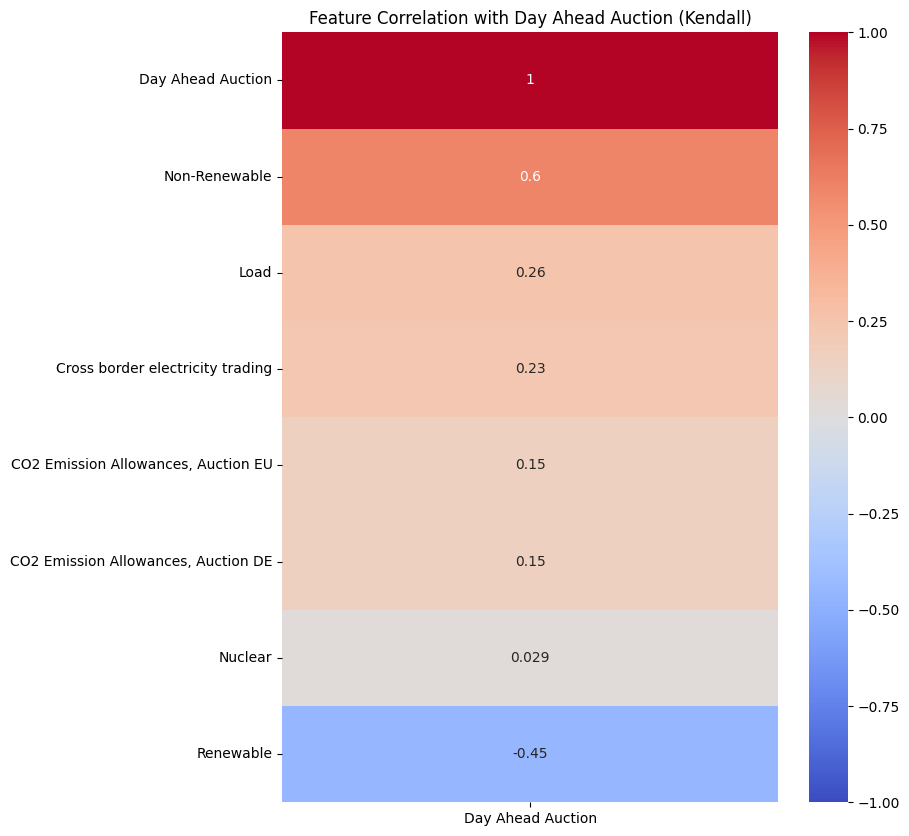

,Cross border electricity trading,Nuclear,Non-Renewable,Renewable,Load,Day Ahead Auction,"CO2 Emission Allowances, Auction DE","CO2 Emission Allowances, Auction EU"
Date,,,,,,,,
2023-01-01 00:00:00,-12557.67,2459.170000,9146.69,38384.86,38536.48,-5.17,83.41,84.10
2023-01-01 01:00:00,-15382.58,2458.600000,8925.66,39415.38,37935.26,-1.07,83.41,84.10
2023-01-01 02:00:00,-16357.50,2459.640000,8902.44,39610.49,37103.11,-1.47,83.41,84.10
2023-01-01 03:00:00,-14005.92,2460.480000,8901.05,37023.62,36139.27,-5.08,83.41,84.10
2023-01-01 04:00:00,-14544.00,2460.800000,8863.19,36499.65,35711.44,-4.49,83.41,84.10
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-7090.11,2671.735395,8956.61,43212.24,49266.05,9.00,66.60,66.49
2023-12-31 20:00:00,-8253.64,2671.735395,8651.99,43930.70,46113.86,7.95,66.60,66.49
2023-12-31 21:00:00,-8682.10,2671.735395,8651.99,43803.16,44018.78,6.00,66.60,66.49


In [17]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
df.set_index('Date', inplace=True)
explore_data(df)
print("Correlation betwwen all variables")
show_cross_correlation(df,'spearman') 
show_correlation(df, target_column_name)
clean_data(df)

In [18]:
feature_significance_analysis(df, target_column_name)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Day Ahead Auction   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     4892.
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        09:43:25   Log-Likelihood:                -39286.
No. Observations:                8759   AIC:                         7.859e+04
Df Residuals:                    8751   BIC:                         7.864e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -5.2788      4.629     -1.140      0.254     -14.353       3.796
Cross border electricity trading       -0.0020     0.0001    -20.404      0.000      -0.002      -0.002
Nuclear                                -0.0246      0.001    -17.492      0.000      -0.027      -0.022
Non-Renewable                          -0.0016      0.000    -15.844      0.000      -0.002      -0.001
Renewable                              -0.0046   8.86e-05    -51.936      0.000      -0.005      -0.004
Load                                    0.0046   8.17e-05     55.978      0.000       0.004       0.005
CO2 Emission Allowances, Auction DE     0.4880      0.109      4.487      0.000       0.275       0.701
CO2 Emission Allowances, Auction EU     0.6815      0.103      6.606      0.000       0.479       0.884
==============================================================================
Omnibus:                     5739.942   Durbin-Watson:                   0.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1838360.942
Skew:                          -1.976   Prob(JB):                         0.00
Kurtosis:                      73.863   Cond. No.                     1.29e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

                     Cross border electricity trading  Nuclear  Non-Renewable  \
Date                                                                            
2023-01-01 00:00:00                         -12557.67  2459.17        9146.69   
2023-01-01 01:00:00                         -15382.58  2458.60        8925.66   
2023-01-01 02:00:00                         -16357.50  2459.64        8902.44   
2023-01-01 03:00:00                         -14005.92  2460.48        8901.05   
2023-01-01 04:00:00                         -14544.00  2460.80        8863.19   

                     Renewable      Load  Day Ahead Auction  \
Date                                                          
2023-01-01 00:00:00   38384.86  38536.48              -5.17   
2023-01-01 01:00:00   39415.38  37935.26              -1.07   
2023-01-01 02:00:00   39610.49  37103.11              -1.47   
2023-01-01 03:00:00   37023.62  36139.27              -5.08   
2023-01-01 04:00:00   36499.65  35711.44              

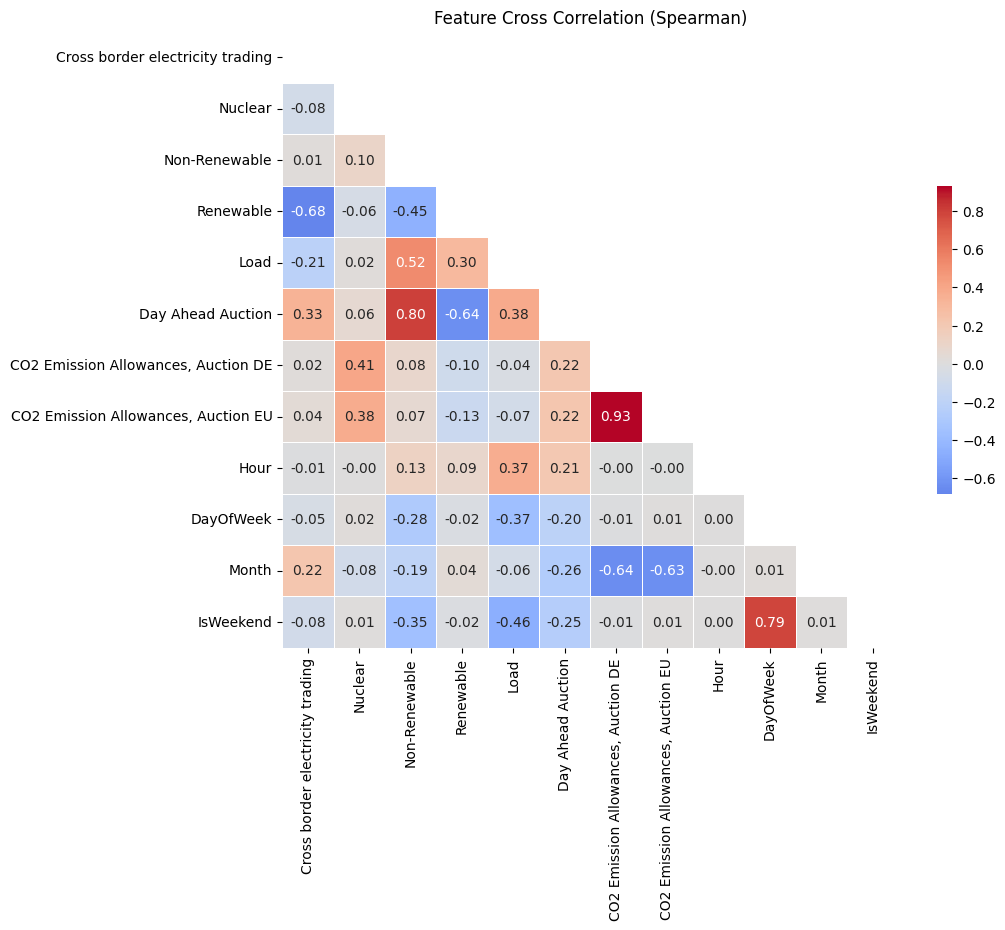

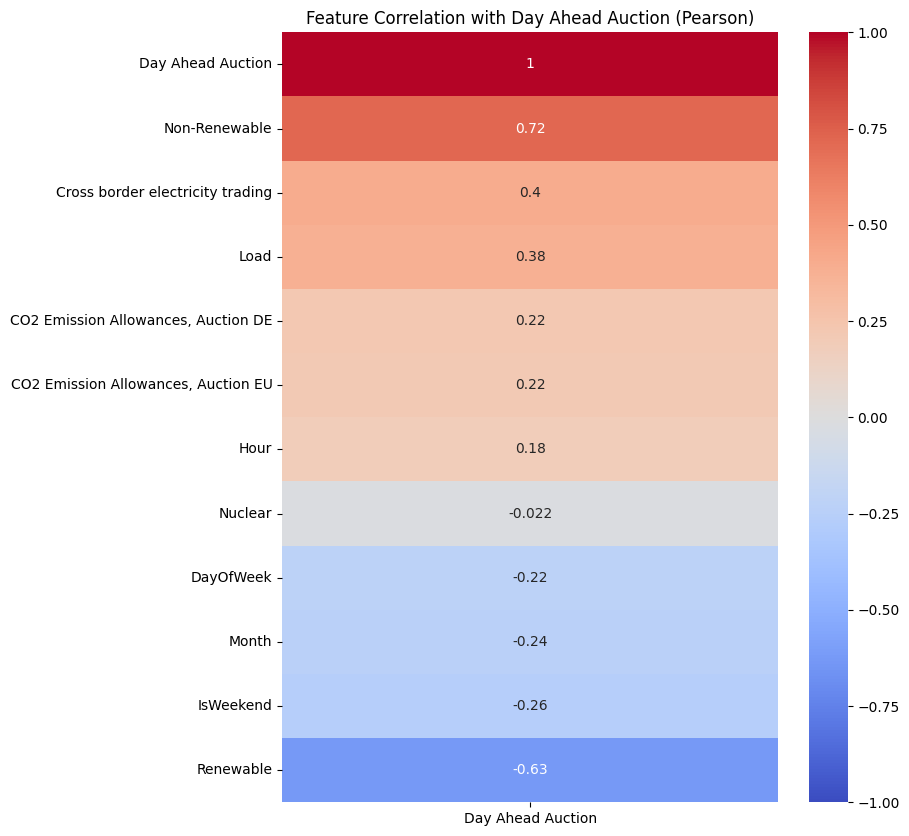

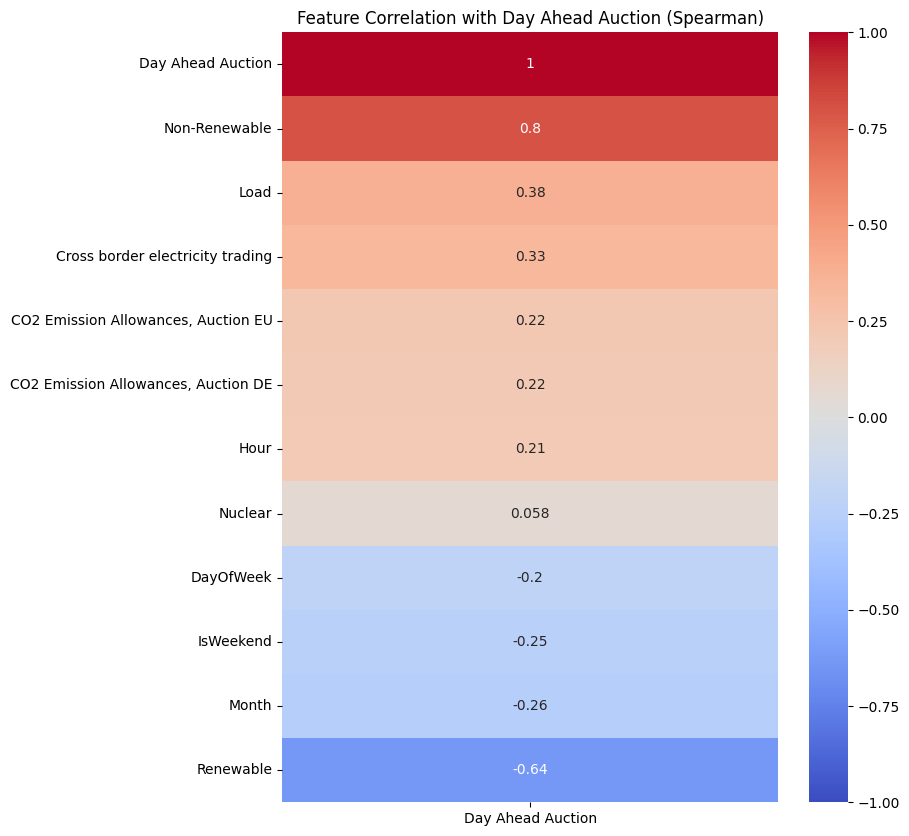

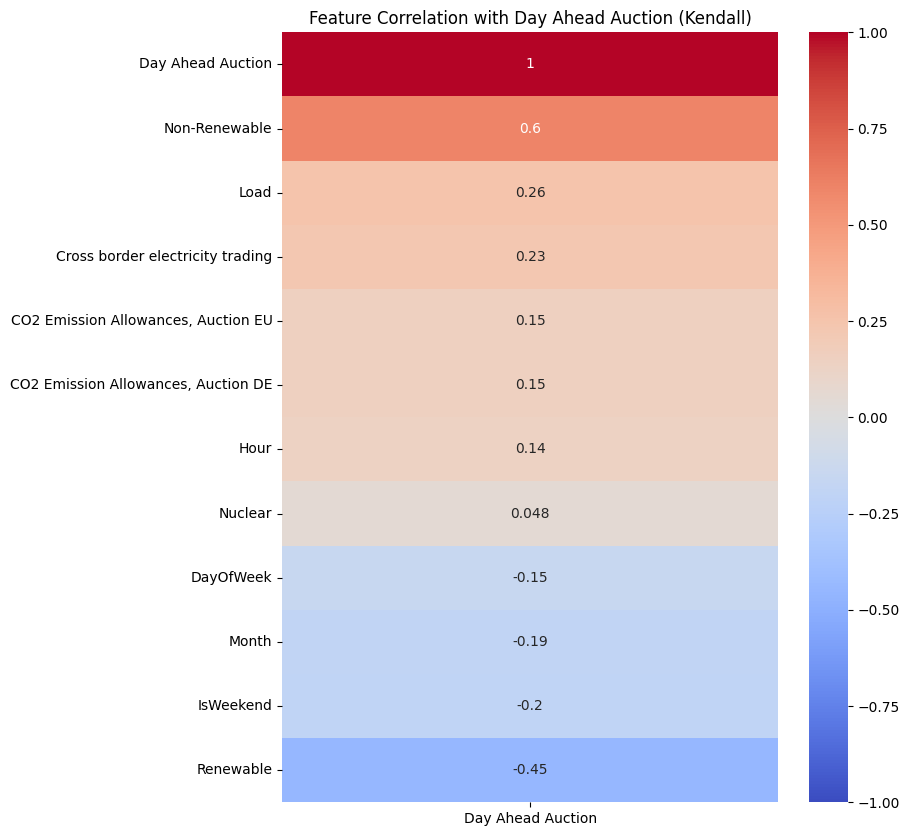

In [19]:
#df = df.drop(['Nuclear'], axis=1)
df= engineer_features(df)
print(df.head())
show_cross_correlation(df,'spearman') 
show_correlation(df, target_column_name)

In [20]:
df = clean_data(df)
            #centrer et reduire
X_scaled, y = transform_data(df, target_column_name, ['Hour', 'DayOfWeek', 'Month', 'IsWeekend'])
            #splitting the data
#X_train, X_test, y_train, y_test = time_series_split(X_scaled, y)
X_train, X_test, y_train, y_test, dates_train, dates_test = time_series_split(X_scaled, y, n_splits=5)

Make sure transformation is well done:
                     Cross border electricity trading   Nuclear  \
Date                                                              
2023-01-01 00:00:00                         -1.997174 -1.256731   
2023-01-01 01:00:00                         -2.403129 -1.260101   
2023-01-01 02:00:00                         -2.543231 -1.253952   
2023-01-01 03:00:00                         -2.205295 -1.248986   
2023-01-01 04:00:00                         -2.282621 -1.247094   

                     Non-Renewable  Renewable      Load  \
Date                                                      
2023-01-01 00:00:00      -1.094203   0.683095 -1.514019   
2023-01-01 01:00:00      -1.118782   0.764334 -1.580404   
2023-01-01 02:00:00      -1.121365   0.779715 -1.672287   
2023-01-01 03:00:00      -1.121519   0.575784 -1.778711   
2023-01-01 04:00:00      -1.125729   0.534478 -1.825951   

                     CO2 Emission Allowances, Auction DE  \
Date             

1. **Objective Function for SVR Optimization**:
   $$ \min_{w, b, \xi, \xi^*} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*) $$

2. **Constraints**:
   $$ y_i - w \cdot \phi(x_i) - b \leq \varepsilon + \xi_i $$
   $$ w \cdot \phi(x_i) + b - y_i \leq \varepsilon + \xi_i^* $$
   $$ \xi_i, \xi_i^* \geq 0 $$

3. **Loss Function (Epsilon-Insensitive Loss)**:
   $$ L_{\varepsilon}(y, f(x)) = \max(0, |y - f(x)| - \varepsilon) $$

4. **Kernel Trick**:
   If using the kernel trick, the optimization problem is formulated in the dual space using the kernel function $ k(x_i, x_j) $


\begin{equation}
\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^*} \frac{1}{2} \mathbf{w}^T\mathbf{w} + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
\end{equation}
\text{s.t.}
\begin{equation}
\begin{cases}
y_i - (\mathbf{w}^T\mathbf{x}_i + b) \leq \epsilon + \xi_i, \\
(\mathbf{w}^T\mathbf{x}_i + b) - y_i \leq \epsilon + \xi_i^*, \\
\xi_i, \xi_i^* \geq 0
\end{cases}
\end{equation}
Here, $\epsilon$ represents the maximum value of tolerable error, while $\xi_i$ and $\xi_i^*$ denote slack variables that measure the degree to which predictions can deviate from the actual values within the $\epsilon$-insensitive zone. The parameter $C$ balances the trade-off between the flatness of the SVR function and the amount up to which deviations larger than $\epsilon$ are tolerated.

\text{where } \epsilon \text{ denotes the maximum value of tolerable error, } \boldsymbol{\xi} \text{and} \boldsymbol{\xi}^* \text{ are the distances between actual values and the corresponding boundary values of } $\epsilon$text{-tube,} C > 0 \text{decides the trade-off of generalization ability and training error. This problem can be solved by making use of the Karush–Kuhn–Tucker's (KKT) conditions. Then, the traditional SVR would be the following linear regression function}
\begin{equation}
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b,
\end{equation}
\text{where} \mathbf{w} \text{represents the weight vector; } b \text{represents the bias.}

\text{By employing the "kernel trick", SVR has been extended to solve nonlinear regression problems with a linear method in an appropriate feature space. Thus, the performance of SVR is determined by the type of kernel function and the settings of kernel parameters.}

\text{The following four types of kernel function, namely linear, tanh, polynomial, and Gaussian kernels, are commonly employed in the related area. The linear kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^T\mathbf{z},
\end{equation}
\text{the tanh kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = \tanh(g\mathbf{x}^T\mathbf{z} + c),
\end{equation}
\text{the polynomial kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z} + c)^d,
\end{equation}
\text{and the Gaussian kernel is}
\begin{equation}
K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{(\mathbf{x} - \mathbf{z})^2}{2 \sigma^2}\right),
\end{equation}
\text{where } g \text{ is the slope of the tanh kernel, } c \text{ is the offset set of polynomial and tanh kernel, } d \text{ is the degree of the polynomial kernel, and } \sigma \text{ is the width of the Gauss kernel.}


To minimize the prediction error within a specified tolerance, the objective of Support Vector Regression (SVR) is given by:

$$
\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^*} \frac{1}{2} \mathbf{w}^T\mathbf{w} + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
$$

The constraints ensuring that the predictions remain within the error tolerance $\epsilon$ for each observation $i$ are:

$$
\begin{aligned}
y_i - (\mathbf{w}^T\mathbf{x}_i + b) &\leq \epsilon + \xi_i, \\
(\mathbf{w}^T\mathbf{x}_i + b) - y_i &\leq \epsilon + \xi_i^*, \\
\xi_i, \xi_i^* &\geq 0
\end{aligned}
$$

Here, $\epsilon$ represents the maximum value of tolerable error, while $\xi_i$ and $\xi_i^*$ denote slack variables that measure the degree to which predictions can deviate from the actual values within the $\epsilon$-insensitive zone. The parameter $C$ balances the trade-off between the flatness of the SVR function and the amount up to which deviations larger than $\epsilon$ are tolerated.

The SVR model predicts new values using the function:

$$
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b,
$$

which is linear in the feature space. To allow for non-linear relationships, kernel functions are used to map the inputs into a higher-dimensional space, facilitating the discovery of non-linear decision boundaries.

Common kernel functions include:

Linear kernel:

$$
K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^T\mathbf{z},
$$

Tanh kernel:

$$
K(\mathbf{x}, \mathbf{z}) = \tanh(g\mathbf{x}^T\mathbf{z} + c),
$$

Polynomial kernel:

$$
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T\mathbf{z} + c)^d,
$$

Gaussian kernel:

$$
K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{(\mathbf{x} - \mathbf{z})^2}{2 \sigma^2}\right),
$$

Each kernel function comes with parameters that need to be fine-tuned for the model to perform optimally on the given data.


# Support Vector Regression (SVR) with Time Series Split in scikit-learn

In our study, we employ the Support Vector Regression (SVR) implementation from the `scikit-learn` library in Python to model time-series data. Time series data inherently contain temporal dependencies, so care must be taken to ensure these dependencies are preserved during model training and validation.

## Time Series Split

To validate our SVR model, we use the TimeSeriesSplit cross-validator from `scikit-learn`. This technique splits the dataset into $k$ sequential folds, each fold consisting of a contiguous time block. Unlike standard cross-validation methods that shuffle data before splitting, TimeSeriesSplit maintains the order of the samples.

The splitting of the dataset into $k$ folds is performed as follows:

1. The first fold contains the first $n_{1}$ samples as the training set, followed by the next $n_{\text{test}}$ samples as the test set.
2. The second fold includes the first $n_{1} + n_{\text{test}}$ samples in the training set, and the subsequent $n_{\text{test}}$ samples as the test set.
3. This process continues until the $k^{th}$ fold, which uses all remaining samples after the $(k-1)^{th}$ fold for training, and the remaining samples (if any) for testing.

Mathematically, for each split $i$, the training and test sets are defined as:

$$
\text{Train}_i = \{1, 2, ..., n_{1} + (i - 1) \times n_{\text{test}}\}
$$

$$
\text{Test}_i = \{n_{1} + (i - 1) \times n_{\text{test}} + 1, ..., n_{1} + i \times n_{\text{test}}\}
$$

where $n_{1}$ is the size of the initial training set and $n_{\text{test}}$ is the size of the test set in each fold.

By using this method, we ensure that the validation of our SVR model respects the temporal sequence of the data, which is crucial for the predictive accuracy of time-series models.


In [21]:
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
}


In [22]:
# Specify distributions rather than a list of options
param_dist = { # for random research
    'C': reciprocal(0.1, 1000),
    'gamma': expon(scale=1.0),
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

In [23]:
#######------------------- Model training and evaluation
# Hyperparameter tuning
start_timeCalibration= time.time()
best_params, best_score = tune_hyperparameters(X_train, y_train, SVR(), param_grid)
end_timeCalibration = time.time()
calibration_time = end_timeCalibration - start_timeCalibration

In [24]:
print(f"Calibration time for Grid Research: {calibration_time} seconds")

Calibration time for Grid Research: 90.84175705909729 seconds


In [25]:
start_timeCalibrationRnd = time.time()
best_paramsRandom, best_scoreRandom = perform_random_search(X_train, y_train, SVR(), param_dist, n_iter=100)
end_timeCalibrationRnd = time.time()
calibration_timeRnd = end_timeCalibrationRnd - start_timeCalibrationRnd
print(f"Calibration time for Random search: {calibration_timeRnd} seconds")

Calibration time for Random search: 482.65488600730896 seconds


In [26]:
start_time_training= time.time()
model= train_model(X_train, y_train,"SVR", best_params)   #here we train the model
model2 = train_model(X_train, y_train, "SVR", best_paramsRandom)
end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Training time: {training_time} seconds")

Training time: 2.412540912628174 seconds


## Evaluation Metrics for Regression Models

We evaluate the performance of our regression models using the following metrics:

- **R-squared ($R^2$)**: The coefficient of determination, $R^2$, indicates the proportion of variance in the dependent variable that can be predicted from the independent variables. It is defined as:
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
  $$
  where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $\bar{y}$ is the mean of the actual values. An $R^2$ of 1 indicates perfect prediction accuracy.

- **Mean Squared Error (MSE)**: Measures the average of the squares of the errors, which is the average squared difference between the estimated values and the actual value.
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
  A lower MSE indicates a more accurate model.

- **Mean Absolute Error (MAE)**: Represents the average magnitude of the errors in a set of predictions, without considering their direction.
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$
  MAE is particularly useful when large errors are equally as undesirable as small ones.

- **Root Mean Square Error (RMSE)**: The square root of the mean square error, giving us the standard deviation of the residuals.
  $$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
  $$
  RMSE can highlight large errors because they will have a disproportionately large effect on the value of the RMSE.


In [27]:
predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)

Mean Squared Error: 348.9473932020559
Mean Absolute Error: 14.717457594222584
Root Mean Squared Error: 18.68013365054051
R^2 Score: 0.8375689798192679


In [28]:
print(f"model with random search")
evaluate_model(model2, X_test, y_test)

model with random search
Mean Squared Error: 432.84538572048825
Mean Absolute Error: 14.42861074276535
Root Mean Squared Error: 20.804936570931627
R^2 Score: 0.7985154239499068


(array([67.09879059, 79.237905  , 86.55605139, ..., 67.35853762,
        64.18620264, 61.58277905]),
 432.84538572048825,
 14.42861074276535,
 20.804936570931627,
 0.7985154239499068)

In [29]:
predictions1, mse1, mae1, rmse1, r2= evaluate_model(model2, X_test, y_test)

Mean Squared Error: 432.84538572048825
Mean Absolute Error: 14.42861074276535
Root Mean Squared Error: 20.804936570931627
R^2 Score: 0.7985154239499068


In [30]:
def autocorrel(target_column, lag, title="Autocorrelation Function"):
    plot_acf(target_column, lags= lag)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.show()

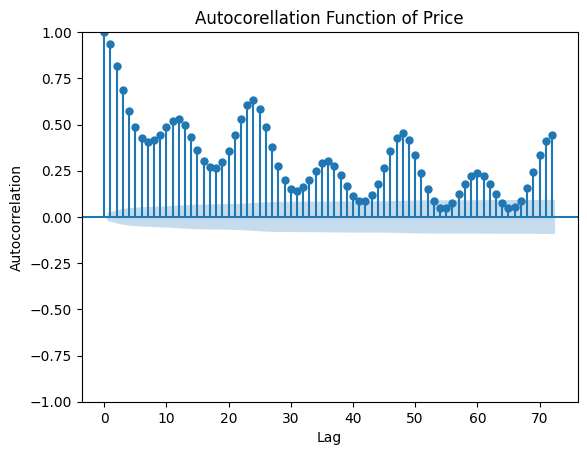

In [31]:
autocorrel(df["Day Ahead Auction"], 72, "Autocorellation Function of Price")

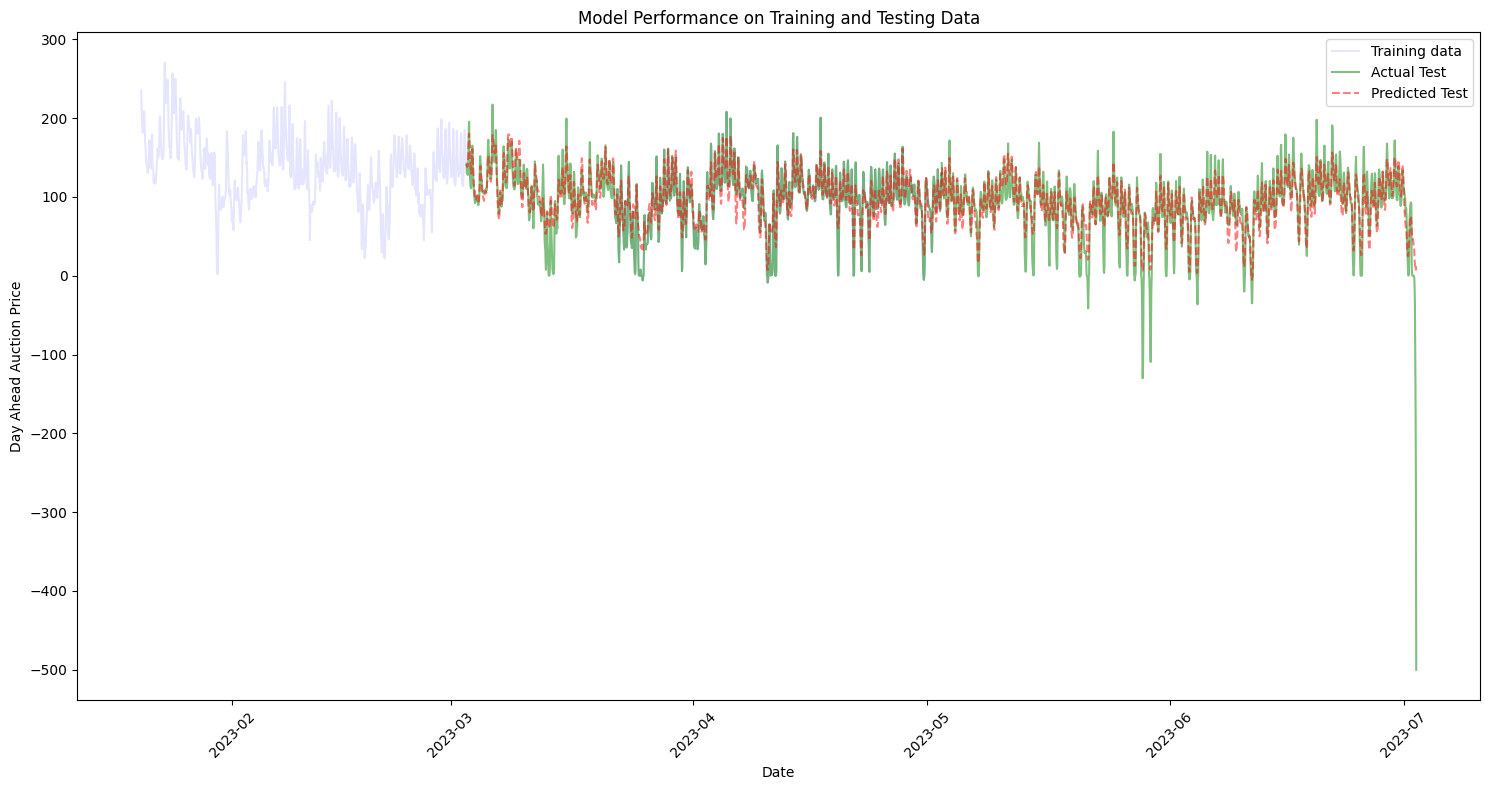

In [32]:
plot_training_testing(model, X_scaled, y, dates_train[:2], dates_test[:2])  # Example for first two splits

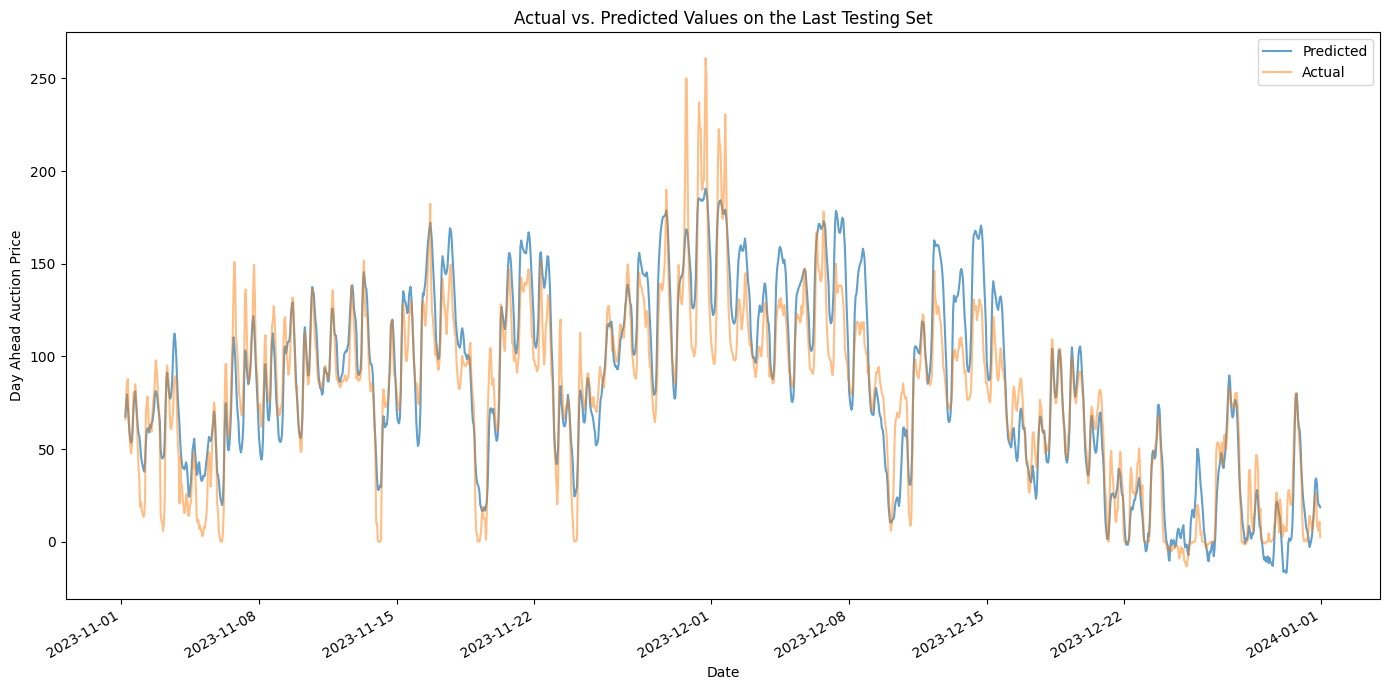

In [33]:
plot_last_test_set_predictions(model, X_scaled, y, dates_train, dates_test)

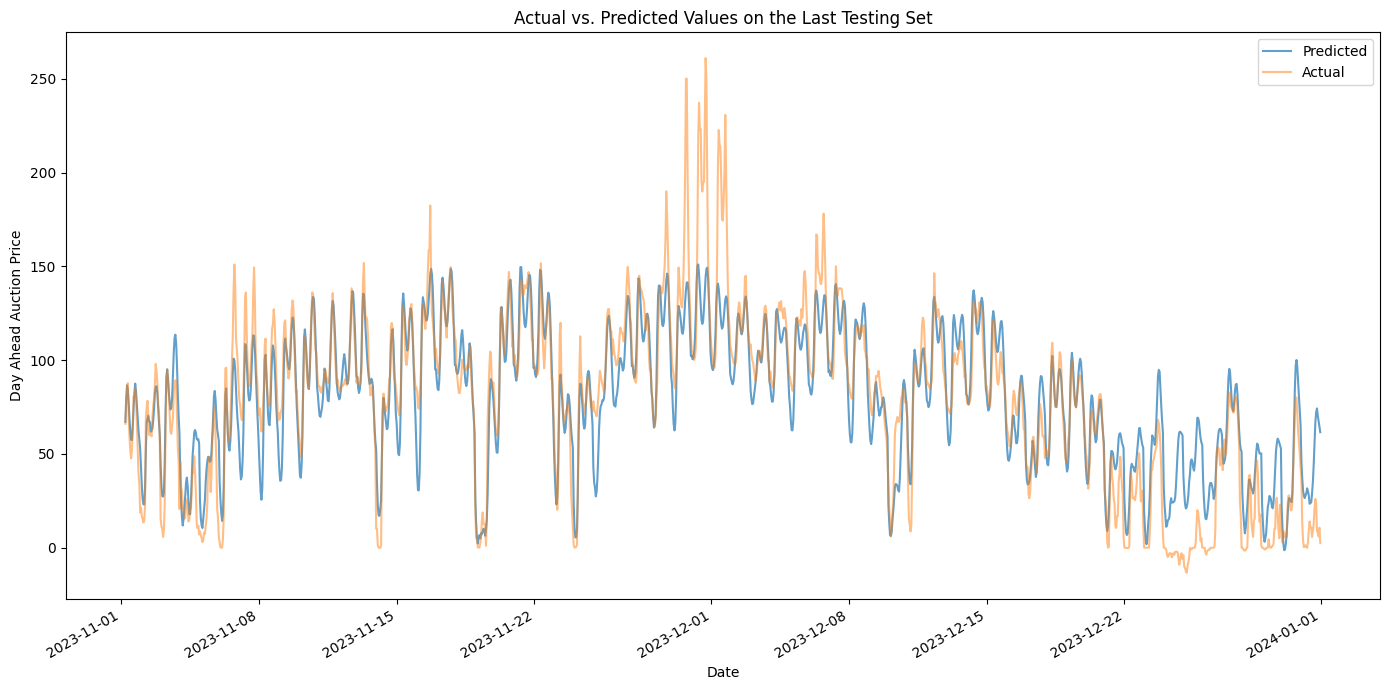

In [34]:
plot_last_test_set_predictions(model2, X_scaled, y, dates_train, dates_test)

We remark that the model with random search got better R2 and better MAE, but it fails to predict the spikes 

Let's get back to something that we had to do before. look at the correalation between teh price and teh features


SVR and ARIMA

The forecasting model developed in this study employs a sequential two-step approach to address the inherent complexities in the time series data of electricity spot prices. Initially, the model implements a Seasonal and Trend decomposition using Loess (STL), a non-parametric method that isolates the time series into three distinct components: trend, seasonality, and the remainder (residuals). This decomposition facilitates a clearer analysis by separating the systematic structures and the more stochastic or irregular fluctuations within the data.

The trend component reflects the long-term progression of the prices, encapsulating shifts that are not of a fixed frequency. The seasonal component captures regular patterns that recur over fixed periods, such as daily or weekly cycles commonly observed in electricity prices. The remainder, composed of residuals, represents the non-systematic variation unaccounted for by the trend and seasonal components.

Following the decomposition, the residuals — now stripped of the trend and seasonal influences — undergo modeling via an Autoregressive Integrated Moving Average (ARIMA) process. This step aims to model the autocorrelated structure of the residuals, focusing on the internal dynamics of the time series data that are not explained by the deterministic components extracted earlier.

we will restart the treatment of the data 

In [35]:
from statsmodels.tsa.seasonal import STL

In [36]:
import statsmodels.api as sm
def test_stationnarity(data):
    result = sm.tsa.adfuller(data)

    # Afficher les résultats
    print('Valeur de la statistique ADF :', result[0])
    print('p-valeur :', result[1])
    print('Valeurs critiques :', result[4])

    if result[0] < result[4]['5%']:
        print("La série est stationnaire.")
        return  True
    else:
        print("La série n'est pas stationnaire.")
        return False

In [53]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
df.set_index('Date', inplace=True)
clean_data(df)

,Cross border electricity trading,Nuclear,Non-Renewable,Renewable,Load,Day Ahead Auction,"CO2 Emission Allowances, Auction DE","CO2 Emission Allowances, Auction EU"
Date,,,,,,,,
2023-01-01 00:00:00,-12557.67,2459.170000,9146.69,38384.86,38536.48,-5.17,83.41,84.10
2023-01-01 01:00:00,-15382.58,2458.600000,8925.66,39415.38,37935.26,-1.07,83.41,84.10
2023-01-01 02:00:00,-16357.50,2459.640000,8902.44,39610.49,37103.11,-1.47,83.41,84.10
2023-01-01 03:00:00,-14005.92,2460.480000,8901.05,37023.62,36139.27,-5.08,83.41,84.10
2023-01-01 04:00:00,-14544.00,2460.800000,8863.19,36499.65,35711.44,-4.49,83.41,84.10
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-7090.11,2671.735395,8956.61,43212.24,49266.05,9.00,66.60,66.49
2023-12-31 20:00:00,-8253.64,2671.735395,8651.99,43930.70,46113.86,7.95,66.60,66.49
2023-12-31 21:00:00,-8682.10,2671.735395,8651.99,43803.16,44018.78,6.00,66.60,66.49


In [55]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
def adf_test_over_intervals(data, intervals):
    """
    Performs the Dickey-Fuller test on various time intervals.

    Parameters:
    - data: pd.Series, the time series data to test
    - intervals: list of int, the intervals in hours to test
    
    Returns:
    - results: dict, a dictionary containing the interval and p-value pairs
    """
    results = {}
    for interval in intervals:
        subset = data[:interval]
        result = adfuller(subset)
        p_value = result[1]
        results[interval] = p_value
        print(f"Interval: {interval} hours, ADF Statistic: {result[0]}, p-value: {p_value}")
    return results

In [56]:
intervals = [24, 48, 24*7, 24*30, len(df[target_column_name])]

# Run the ADF test over the specified intervals
results = adf_test_over_intervals(df[target_column_name], intervals)

Interval: 24 hours, ADF Statistic: -1.361448436136325, p-value: 0.6006124160344238
Interval: 48 hours, ADF Statistic: -1.0398699671757718, p-value: 0.738446422584255
Interval: 168 hours, ADF Statistic: -2.9261853653344336, p-value: 0.04238663325380491
Interval: 720 hours, ADF Statistic: -2.279207230981658, p-value: 0.17876176461208232
Interval: 8759 hours, ADF Statistic: -8.876746020367309, p-value: 1.3515386066736821e-14


In [57]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def differencing_stationarity(df, column, order=1, seasonal_period=None):
    """
    Performs differencing on a column and checks for stationarity.
    Optionally performs seasonal differencing.
    
    Parameters:
    df (pandas.DataFrame): The dataframe containing the time series.
    column (str): The column name of the time series.
    order (int): The order of differencing (default is 1).
    seasonal_period (int): The seasonal period for seasonal differencing (optional).
    
    Returns:
    pandas.DataFrame: The dataframe with differenced column added.
    dict: The ADF test result.
    """
    # Copy the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Differencing
    if seasonal_period:
        differenced_col_name = f'seasonally_differenced_{column}'
        df_copy[differenced_col_name] = df_copy[column].diff(seasonal_period)
        for _ in range(order):
            df_copy[differenced_col_name] = df_copy[differenced_col_name].diff()
    else:
        differenced_col_name = f'differenced_{column}'
        df_copy[differenced_col_name] = df_copy[column]
        for _ in range(order):
            df_copy[differenced_col_name] = df_copy[differenced_col_name].diff()

    # Drop missing values after differencing
    df_copy = df_copy.dropna()

    # ADF Test
    result = adfuller(df_copy[differenced_col_name])
    adf_result = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'used_lag': result[2],
        'number_of_observations': result[3],
        'critical_values': result[4],
        'ic_best': result[5],
    }

    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

    return df_copy, adf_result



In [59]:


result_df, adf_result = differencing_stationarity(df, target_column_name, order=1, seasonal_period=12)

ADF Statistic: -25.420271137878515
p-value: 0.0
Critical Values:
   1%: -3.431101174632551
   5%: -2.86187196907988
   10%: -2.5669467021792536


In [61]:
price= "seasonally_differenced_Day Ahead Auction"
intervals = [24, 48, 24*7, 24*30, len(result_df[price])]

# Run the ADF test over the specified intervals
results2 = adf_test_over_intervals(result_df[price], intervals)

Interval: 24 hours, ADF Statistic: -3.3843501678357435, p-value: 0.011504084109675254
Interval: 48 hours, ADF Statistic: -2.6808824237294244, p-value: 0.07740527007536192
Interval: 168 hours, ADF Statistic: -6.651291511891288, p-value: 5.113124807433783e-09
Interval: 720 hours, ADF Statistic: -16.3964757091692, p-value: 2.663418917636173e-29
Interval: 8746 hours, ADF Statistic: -25.420271137878515, p-value: 0.0


In [62]:

def plot_intervals(df, column_name, intervals):
    """
    Plots the time series for specified intervals.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the time series.
    column_name (str): The column name of the time series.
    intervals (list of int): The list of intervals to plot.
    """
    for interval in intervals:
        if interval > len(df):
            print(f"Interval {interval} exceeds data length {len(df)}. Skipping this interval.")
            continue
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        fig.suptitle(f"Interval: {interval} Hours")

        # Plot original
        df_subset = df.iloc[:interval]
        df_subset[column_name].plot(ax=axes[0], title=f"Original {column_name} - First {interval} hours")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel(column_name)

        # Plot differenced
        df_subset['differenced'] = df_subset[column_name].diff().dropna()
        df_subset['differenced'].plot(ax=axes[1], title=f"Differenced {column_name} - First {interval} hours")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel(f"Differenced {column_name}")

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()


/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_29639/985047412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['differenced'] = df_subset[column_name].diff().dropna()


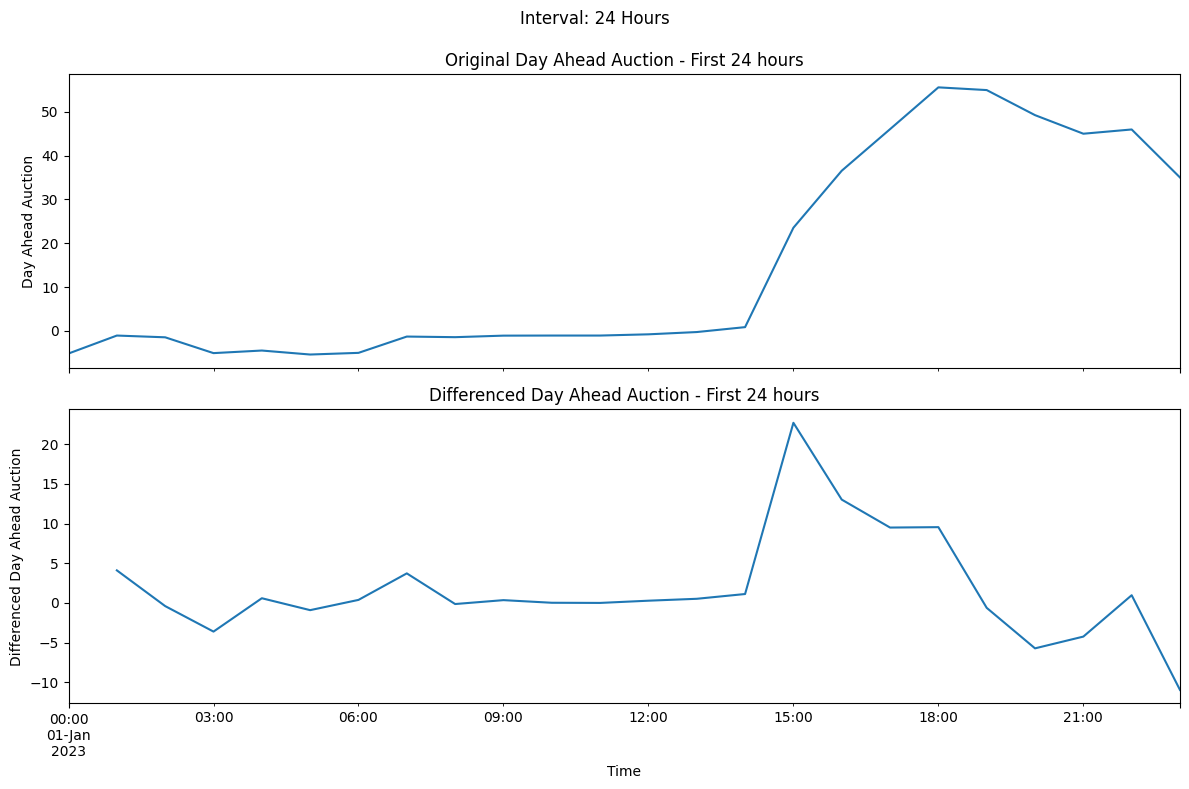

/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_29639/985047412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['differenced'] = df_subset[column_name].diff().dropna()


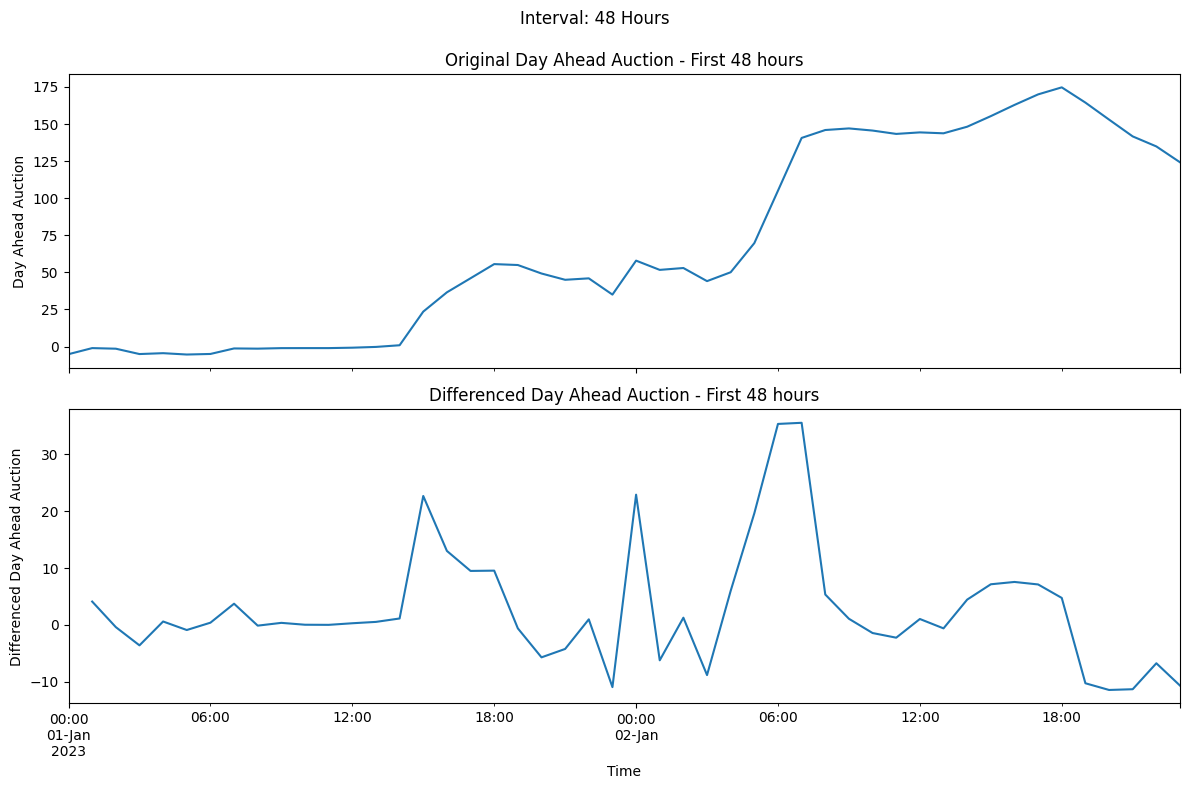

/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_29639/985047412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['differenced'] = df_subset[column_name].diff().dropna()


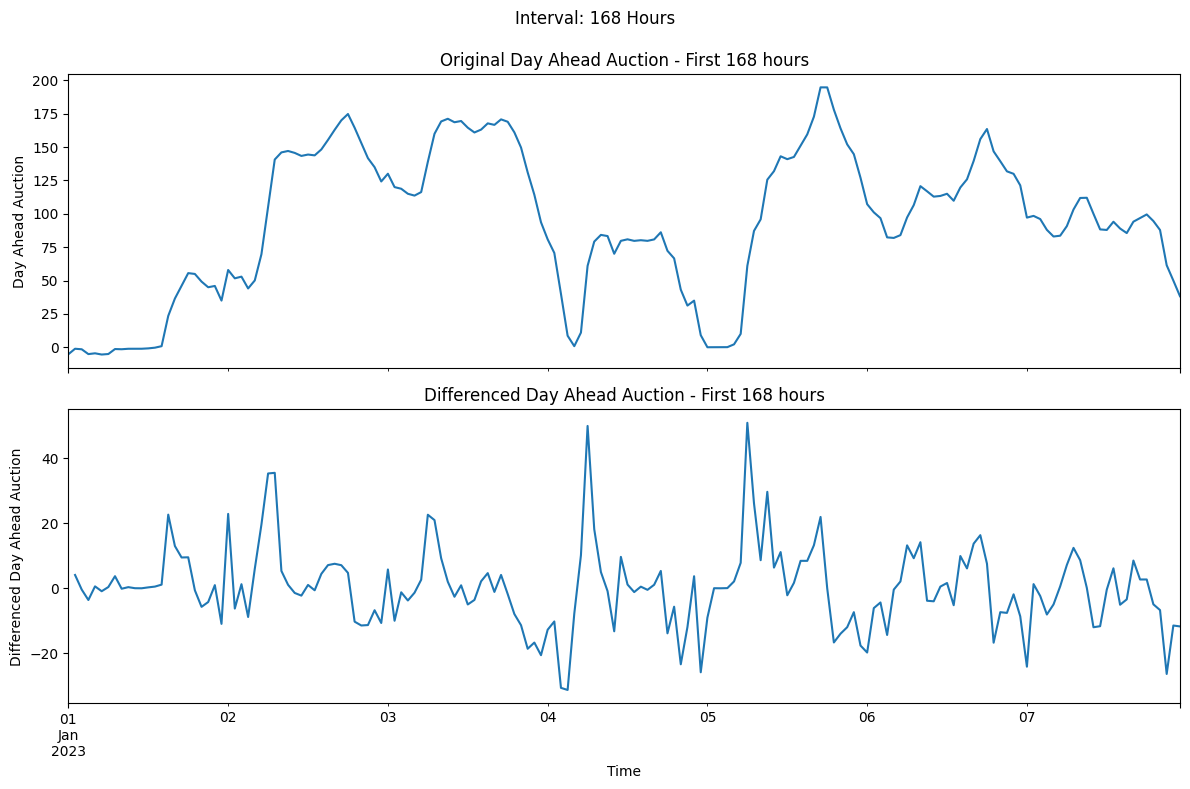

/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_29639/985047412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['differenced'] = df_subset[column_name].diff().dropna()


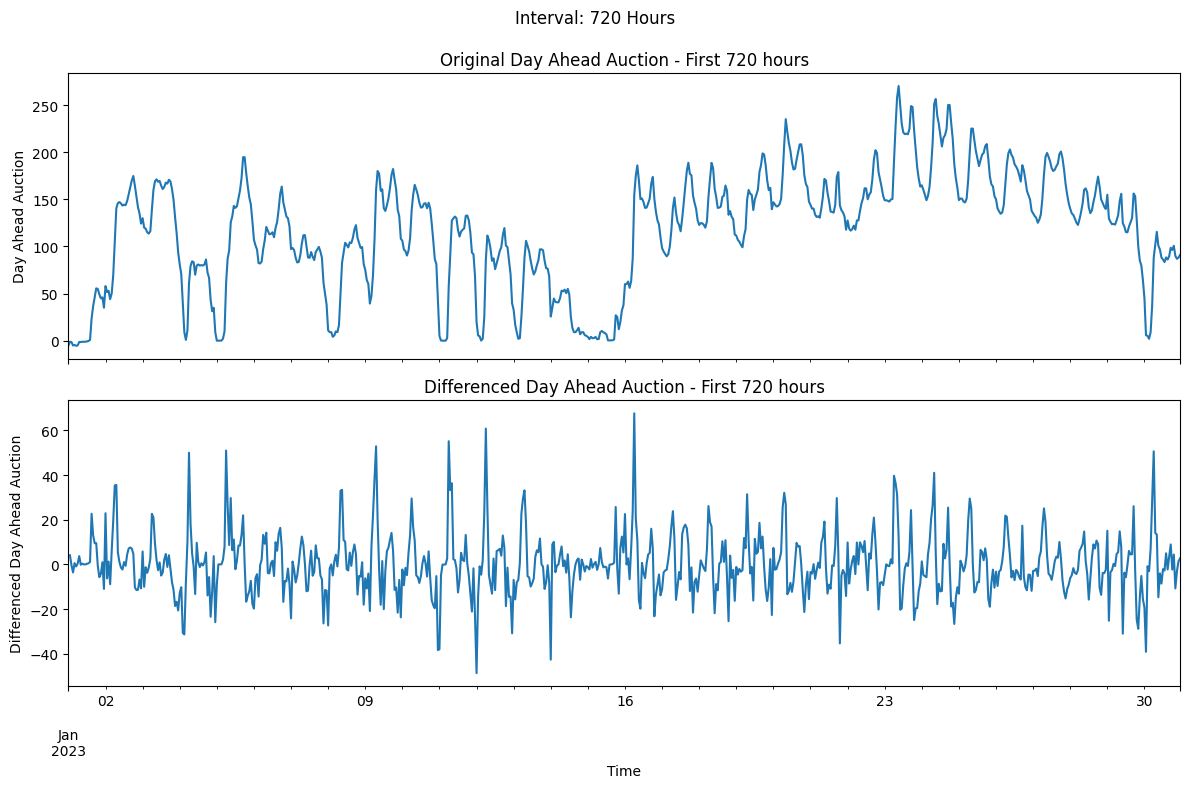

/var/folders/4f/v08z_h8j07n1f5bjfz86lb8h0000gn/T/ipykernel_29639/985047412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['differenced'] = df_subset[column_name].diff().dropna()


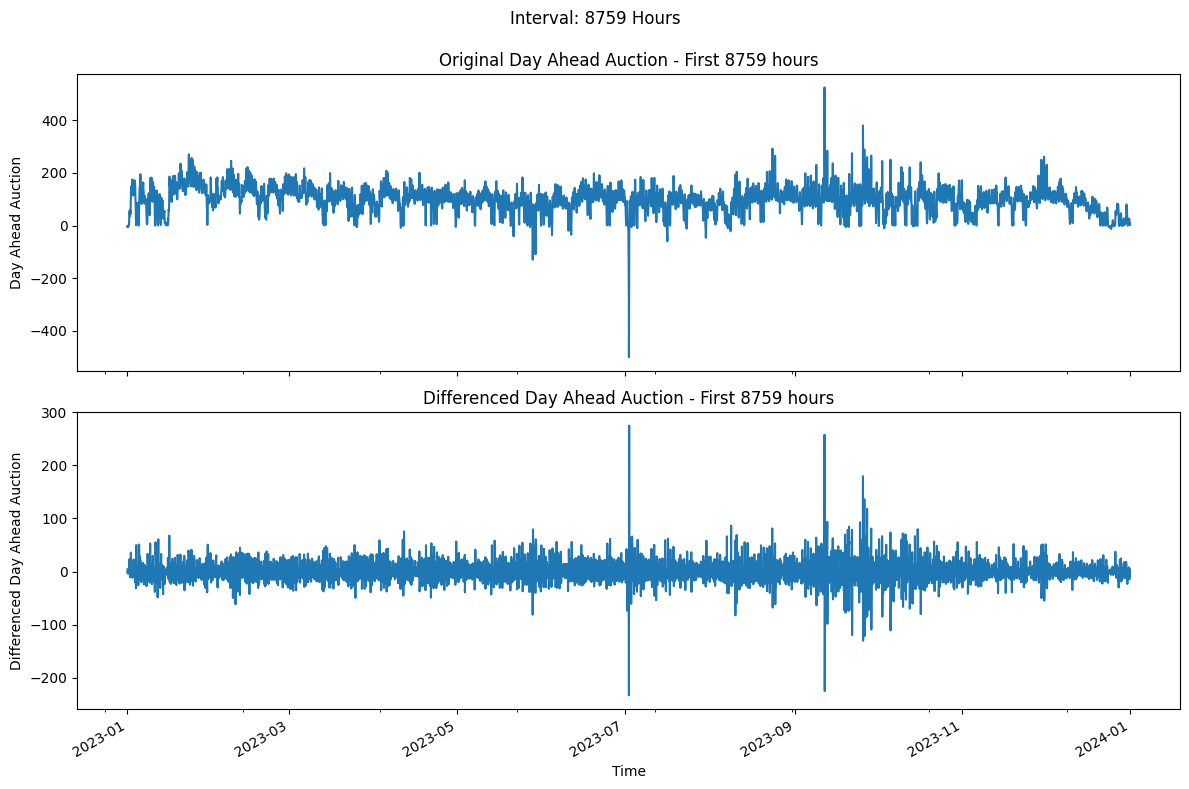

In [64]:


intervals = [24, 48, 24*7, 24*30, len(df[target_column_name])]
plot_intervals(df, target_column_name, intervals)


In [67]:
df= engineer_features(result_df)
df = clean_data(result_df)
            #centrer et reduire
X_scaled, y = transform_data(df, target_column_name, ['Hour', 'DayOfWeek', 'Month', 'IsWeekend'])
            #splitting the data
#X_train, X_test, y_train, y_test = time_series_split(X_scaled, y)
X_train, X_test, y_train, y_test, dates_train, dates_test = time_series_split(X_scaled, y, n_splits=5)

Make sure transformation is well done:
                     Cross border electricity trading   Nuclear  \
Date                                                              
2023-01-01 13:00:00                         -1.800499 -1.278302   
2023-01-01 14:00:00                         -1.690358 -1.292970   
2023-01-01 15:00:00                         -1.454678 -1.314499   
2023-01-01 16:00:00                         -0.957041 -1.301014   
2023-01-01 17:00:00                         -0.584028 -1.273630   

                     Non-Renewable  Renewable      Load  \
Date                                                      
2023-01-01 13:00:00      -1.110669   0.751827 -0.941950   
2023-01-01 14:00:00      -1.102895   0.733423 -0.980684   
2023-01-01 15:00:00      -1.098847   0.627019 -0.939638   
2023-01-01 16:00:00      -1.024249   0.392748 -0.728851   
2023-01-01 17:00:00      -1.047349   0.299299 -0.394453   

                     CO2 Emission Allowances, Auction DE  \
Date             

In [65]:
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
}
# Specify distributions rather than a list of options
param_dist = { # for random research
    'C': reciprocal(0.1, 1000),
    'gamma': expon(scale=1.0),
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}


In [68]:
#######------------------- Model training and evaluation
# Hyperparameter tuning
start_timeCalibration= time.time()
best_params, best_score = tune_hyperparameters(X_train, y_train, SVR(), param_grid)
end_timeCalibration = time.time()
calibration_time = end_timeCalibration - start_timeCalibration
print(f"Calibration time for Grid Research: {calibration_time} seconds")


Calibration time for Grid Research: 97.1022322177887 seconds


In [69]:
start_timeCalibrationRnd = time.time()
best_paramsRandom, best_scoreRandom = perform_random_search(X_train, y_train, SVR(), param_dist, n_iter=100)
end_timeCalibrationRnd = time.time()
calibration_timeRnd = end_timeCalibrationRnd - start_timeCalibrationRnd
print(f"Calibration time for Random search: {calibration_timeRnd} seconds")


Calibration time for Random search: 437.6222257614136 seconds


In [70]:

start_time_training= time.time()
model= train_model(X_train, y_train,"SVR", best_params)   #here we train the model
model2 = train_model(X_train, y_train, "SVR", best_paramsRandom)
end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Training time: {training_time} seconds")

Training time: 2.600679874420166 seconds


Mean Squared Error: 353.9984452922183
Mean Absolute Error: 14.875888468394464
Root Mean Squared Error: 18.81484640628826
R^2 Score: 0.8354338317086109
Mean absolute percentage error: 196207788220385.8
model with random search
Mean Squared Error: 419.8215742997881
Mean Absolute Error: 14.22001906252865
Root Mean Squared Error: 20.489547928145903
R^2 Score: 0.8048340924448303
Mean absolute percentage error: 541085659435760.1
Mean Squared Error: 419.8215742997881
Mean Absolute Error: 14.22001906252865
Root Mean Squared Error: 20.489547928145903
R^2 Score: 0.8048340924448303
Mean absolute percentage error: 541085659435760.1


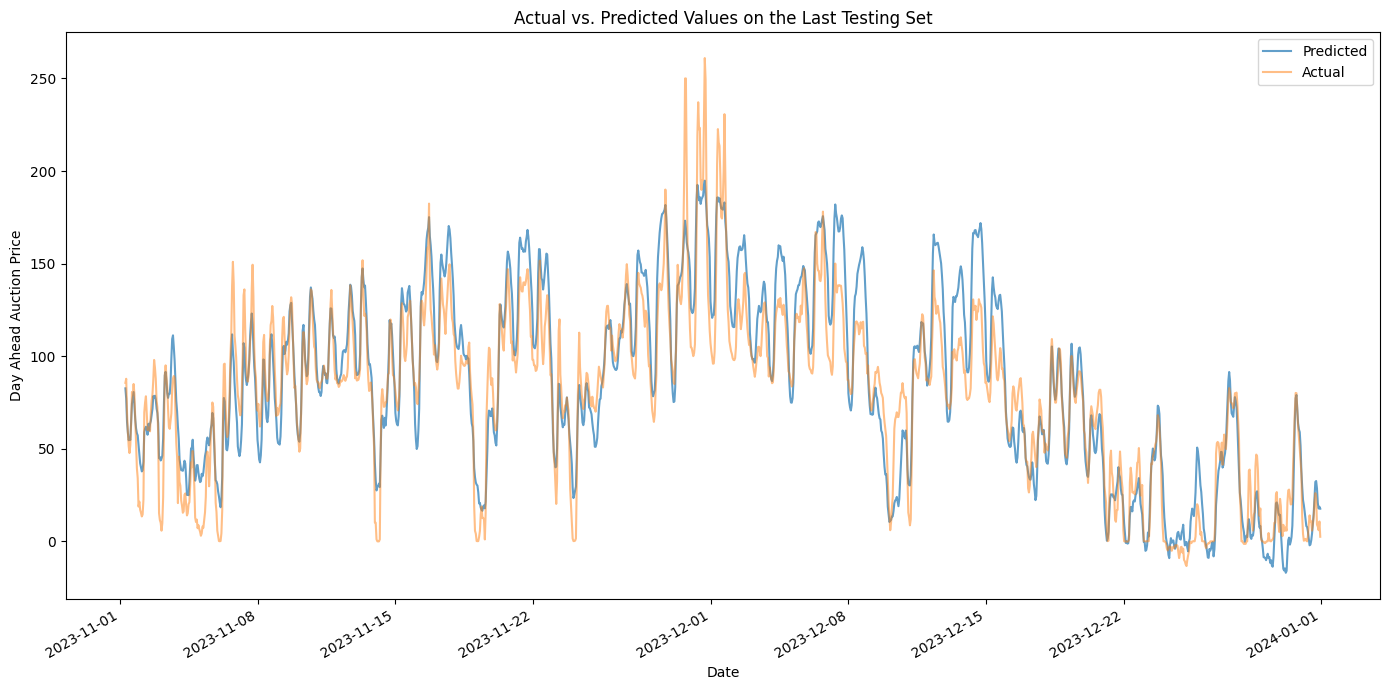

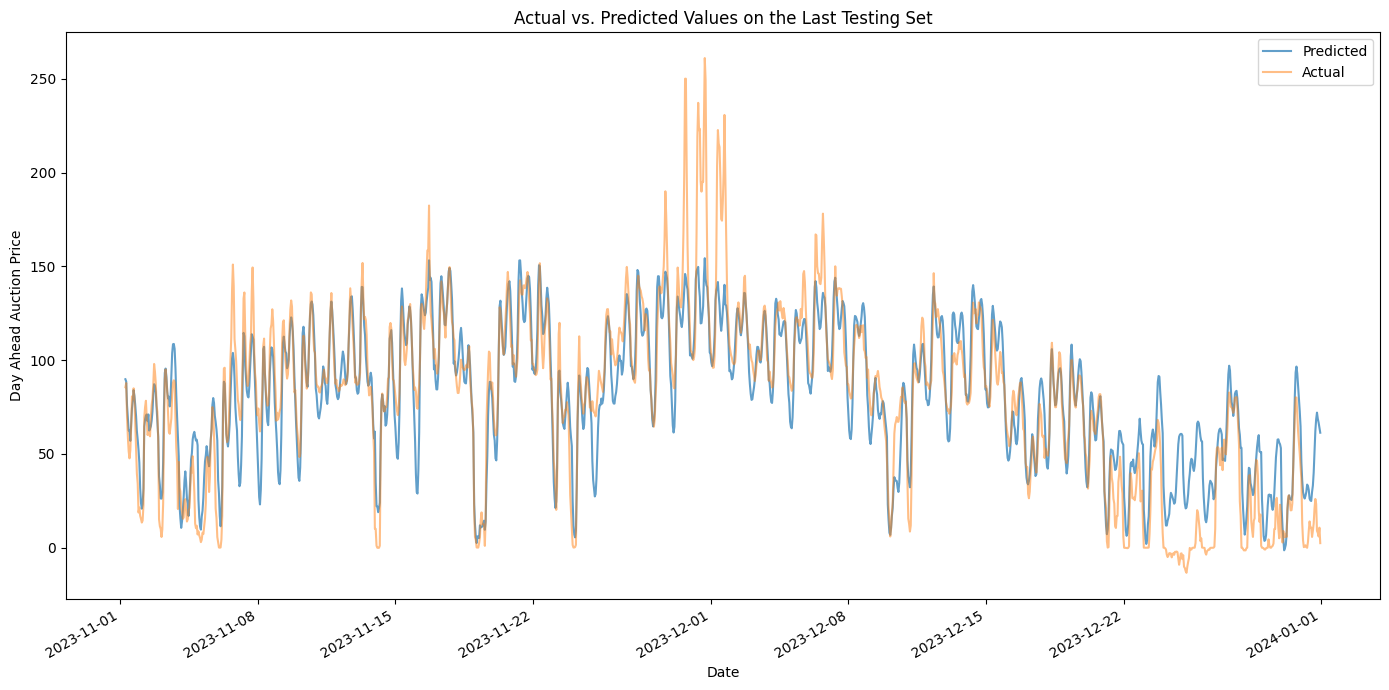

In [83]:
predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)
print(f"model with random search")
evaluate_model(model2, X_test, y_test)
predictions1, mse1, mae1, rmse1, r2= evaluate_model(model2, X_test, y_test)
plot_last_test_set_predictions(model, X_scaled, y, dates_train, dates_test)
plot_last_test_set_predictions(model2, X_scaled, y, dates_train, dates_test)

In [74]:
# Now we implement the naive forecastor for comparison
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def seasonal_naive_forecast(train, test, season_length):
    """
    Forecasts future values using the seasonal naive method.

    Parameters:
    - train: The training data.
    - test: The testing data.
    - season_length: The number of time steps in one seasonal cycle.

    Returns:
    - A forecast Series with the same length as the test data.
    """
    forecast = []
    for i in range(len(test)):
        forecast.append(train.iloc[-season_length + (i % season_length)])
    return pd.Series(forecast, index=test.index)



def evaluate_model(test, forecast):
    """Evaluates the forecast using MAE, RMSE, MAPE, and R-squared."""
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


In [79]:

train_data = df.iloc[:int(len(df) * 0.75)]
test_data = df.iloc[int(len(df) * 0.75):]

# Generate forecast using the seasonal naive method with a daily cycle (24 hours)
season_length = 24
forecast = seasonal_naive_forecast(train_data[target_column_name], test_data[target_column_name], season_length)

# Evaluate the forecast
results = evaluate_model(test_data[target_column_name], forecast)
print(f"Evaluation results: {results}")

Evaluation results: {'MAE': 47.99593049839964, 'RMSE': 61.997124283943506, 'MAPE': 947753403064085.0, 'R2': -0.7273472523130686}


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

def analyze_residuals(y_test, y_pred):
    # Ensure both inputs are numpy arrays
    if hasattr(y_test, 'values'):
        y_test = y_test.values
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Check if both arrays have the same length
    if len(y_test) != len(y_pred):
        raise ValueError("y_test and y_pred do not have the same length.")

    # Calculate residuals
    residuals = y_test - y_pred

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    # Plot Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

    # Display statistical summary
    print("Residuals Statistical Summary:")
    print(f"Mean: {np.mean(residuals)}")
    print(f"Standard Deviation: {np.std(residuals)}")
    print(f"Minimum: {np.min(residuals)}")
    print(f"Maximum: {np.max(residuals)}")
    print(f"Skewness: {stats.skew(residuals)}")
    print(f"Kurtosis: {stats.kurtosis(residuals)}")



In [94]:

predictions

array([82.60006639, 76.94672177, 64.32632614, ..., 17.69509973,
       18.66178055, 17.58586693])

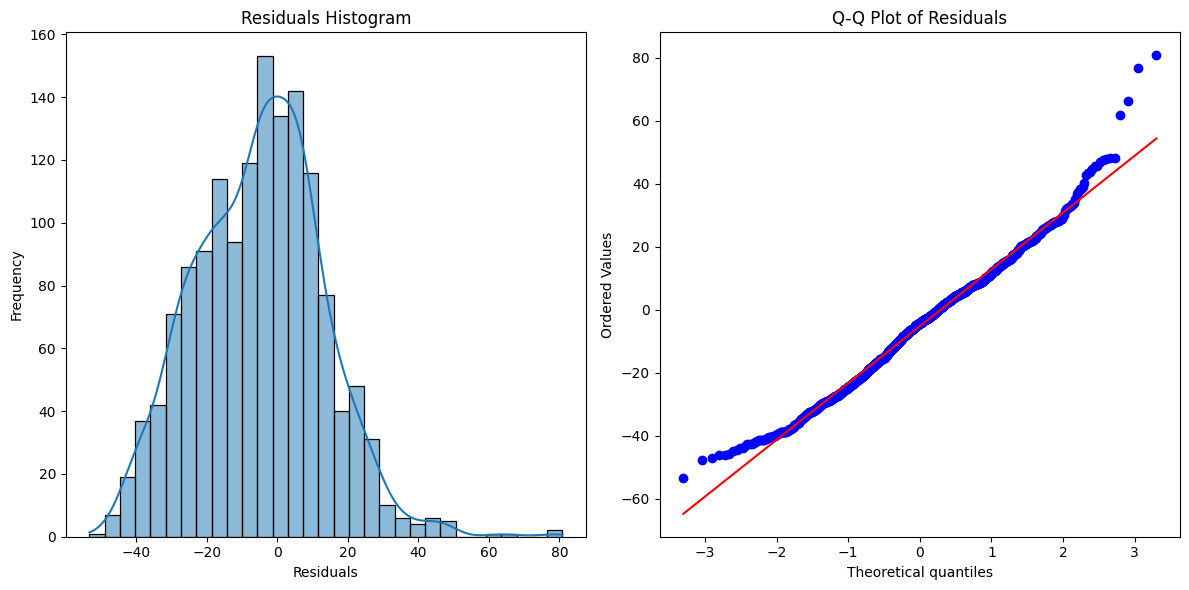

Residuals Statistical Summary:
Mean: -5.180637105620849
Standard Deviation: 18.08754943247102
Minimum: -53.2731838277396
Maximum: 80.86825639174674
Skewness: 0.23619479131509888
Kurtosis: 0.437398813217714


In [99]:
analyze_residuals(y_test, predictions)